In [1]:
!pip install tensorflow-gpu==2.0.0b1

     |████████████████████████████████| 348.9MB 99kB/s 
     |████████████████████████████████| 501kB 43.5MB/s 
     |████████████████████████████████| 3.1MB 29.8MB/s 


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, ConvLSTM2D, ReLU, concatenate, Subtract, Reshape, Input
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

# Google 드라이브를 마운트하려면 이 셀을 실행하세요.
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
def imgLoad(folder, shape, gray=True):
  im_dir = os.path.join("/content/drive/My Drive/workspace/Python/ML_Basic/Images", folder)
  x_train = []
  x_train.append(np.zeros(shape, dtype=np.float32))
  
  file_list = os.listdir(im_dir)
  file_list = sorted(file_list, key=str.lower)
  for name in file_list:
      print(os.path.join(im_dir, name))
      if gray:
        im = cv2.imread(os.path.join(im_dir, name), 0)
      else:
        im = cv2.imread(os.path.join(im_dir, name))
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
      im = cv2.resize(im, dsize = shape[:2])
      im = im.astype(np.float32)/255.
      x_train.append(im)

  # print(os.path.join(im_dir, file_list[0]))
  # im = cv2.imread(os.path.join(im_dir, file_list[0]), 0)
  # im = cv2.resize(im, dsize = (64, 64))
  # im = im.astype(np.float32)/255.
  # # im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
  # x_train.append(im)

  # x_train = np.array(x_train)    
  return x_train
  

In [4]:
# imgSet = imgLoad('ball_imgs')
shape = (256, 256, 3)
imgSet = imgLoad('trainImg', shape, False)
imgGTSet = imgLoad('GroundTruth', shape, False)

/content/drive/My Drive/workspace/Python/ML_Basic/Images/trainImg/106024.jpg
/content/drive/My Drive/workspace/Python/ML_Basic/Images/trainImg/153077.jpg
/content/drive/My Drive/workspace/Python/ML_Basic/Images/trainImg/153093.jpg
/content/drive/My Drive/workspace/Python/ML_Basic/Images/trainImg/181079.jpg
/content/drive/My Drive/workspace/Python/ML_Basic/Images/trainImg/189080.jpg
/content/drive/My Drive/workspace/Python/ML_Basic/Images/trainImg/208001.jpg
/content/drive/My Drive/workspace/Python/ML_Basic/Images/trainImg/209070.jpg
/content/drive/My Drive/workspace/Python/ML_Basic/Images/trainImg/21077.jpg
/content/drive/My Drive/workspace/Python/ML_Basic/Images/trainImg/227092.jpg
/content/drive/My Drive/workspace/Python/ML_Basic/Images/trainImg/24077.jpg
/content/drive/My Drive/workspace/Python/ML_Basic/Images/trainImg/271008.jpg
/content/drive/My Drive/workspace/Python/ML_Basic/Images/trainImg/304074.jpg
/content/drive/My Drive/workspace/Python/ML_Basic/Images/trainImg/326038.jpg
/

In [0]:
shape = (256, 256, 3)

inputs_size = shape
errors_size = (1, 1, 256, 256, 10)

In [0]:
def conv2d(aInput, filter_stack, filter_size, strides=1, padding='same', use_bias=False):
  for i in range(len(filter_stack)):
    if i == len(filter_stack)-1:
      output = Conv2D(filters=filter_stack[i], kernel_size=filter_size, strides=strides, padding=padding, use_bias=use_bias)(aInput)
      return output
    else:
      aInput = Conv2D(filters=filter_stack[i], kernel_size=filter_size, strides=strides, padding=padding, use_bias=use_bias)(aInput)

      
def convLSTM(aInput, filter_stack, filter_size, strides=1, padding='same', use_bias=False, return_sequences=True):
  for i in range(len(filter_stack)):
    if i == len(filter_stack)-1:
      output = ConvLSTM2D(filters=filter_stack[i], kernel_size=filter_size, strides=strides, padding=padding, use_bias=use_bias, return_sequences=False)(aInput)
      return output
    else:
      aInput = ConvLSTM2D(filters=filter_stack[i], kernel_size=filter_size, strides=strides, padding=padding, use_bias=use_bias, return_sequences=return_sequences)(aInput)
      
      
def getError(first, second):
  shape = first.shape
  rshape = (1, shape[1], shape[2], 2*shape[3])
  
  e0 = layers.Subtract()([first, second])
  e1 = layers.Subtract()([second, first])
  E = layers.concatenate([e0, e1], axis=-1)
  E = keras.activations.relu(E)
  E = layers.Reshape(rshape)(E)
  return E

In [0]:
lstm_stacks = [32, 64, 128] 
conv_stacks = [64, 32, 16, 8, 3]

In [0]:
inputs = Input(shape=inputs_size, name='input')
errors = Input(shape=errors_size[1:], name='error')


conv = layers.Conv2D(filters=5, kernel_size=3, strides=1, padding='same', use_bias=True)
A_forE = conv(inputs)
A_forE = ReLU()(A_forE)

R = convLSTM(errors, lstm_stacks, 3, use_bias=True)
Ahat = conv2d(R, conv_stacks, 3, use_bias=True)

Ahat = keras.activations.sigmoid(Ahat)
Ahat_forE = conv(Ahat)
Ahat_forE = ReLU()(Ahat_forE)

E = getError(A_forE, Ahat_forE)

In [0]:
pm = keras.Model(inputs=[inputs, errors], outputs=[Ahat])
hm = keras.Model(inputs=[inputs, errors], outputs=[E])

In [0]:
error_type = 'cosine_similarity'
error_type = 'mean_sqard_error'
error_type = 'binary_crossentropy'
error_type = 'mean_absolute_error'


pm.summary()
hm.summary()
pm.compile('adam', error_type)
hm.compile('adam', error_type)

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
error (InputLayer)              [(None, 1, 256, 256, 0                                            
__________________________________________________________________________________________________
conv_lst_m2d_18 (ConvLSTM2D)    (None, 1, 256, 256,  48512       error[0][0]                      
__________________________________________________________________________________________________
conv_lst_m2d_19 (ConvLSTM2D)    (None, 1, 256, 256,  221440      conv_lst_m2d_18[0][0]            
__________________________________________________________________________________________________
conv_lst_m2d_20 (ConvLSTM2D)    (None, 256, 256, 128 885248      conv_lst_m2d_19[0][0]            
___________________________________________________________________________________________

In [0]:
pm_opt = tf.keras.optimizers.Adam(5e-4, epsilon=1e-3)

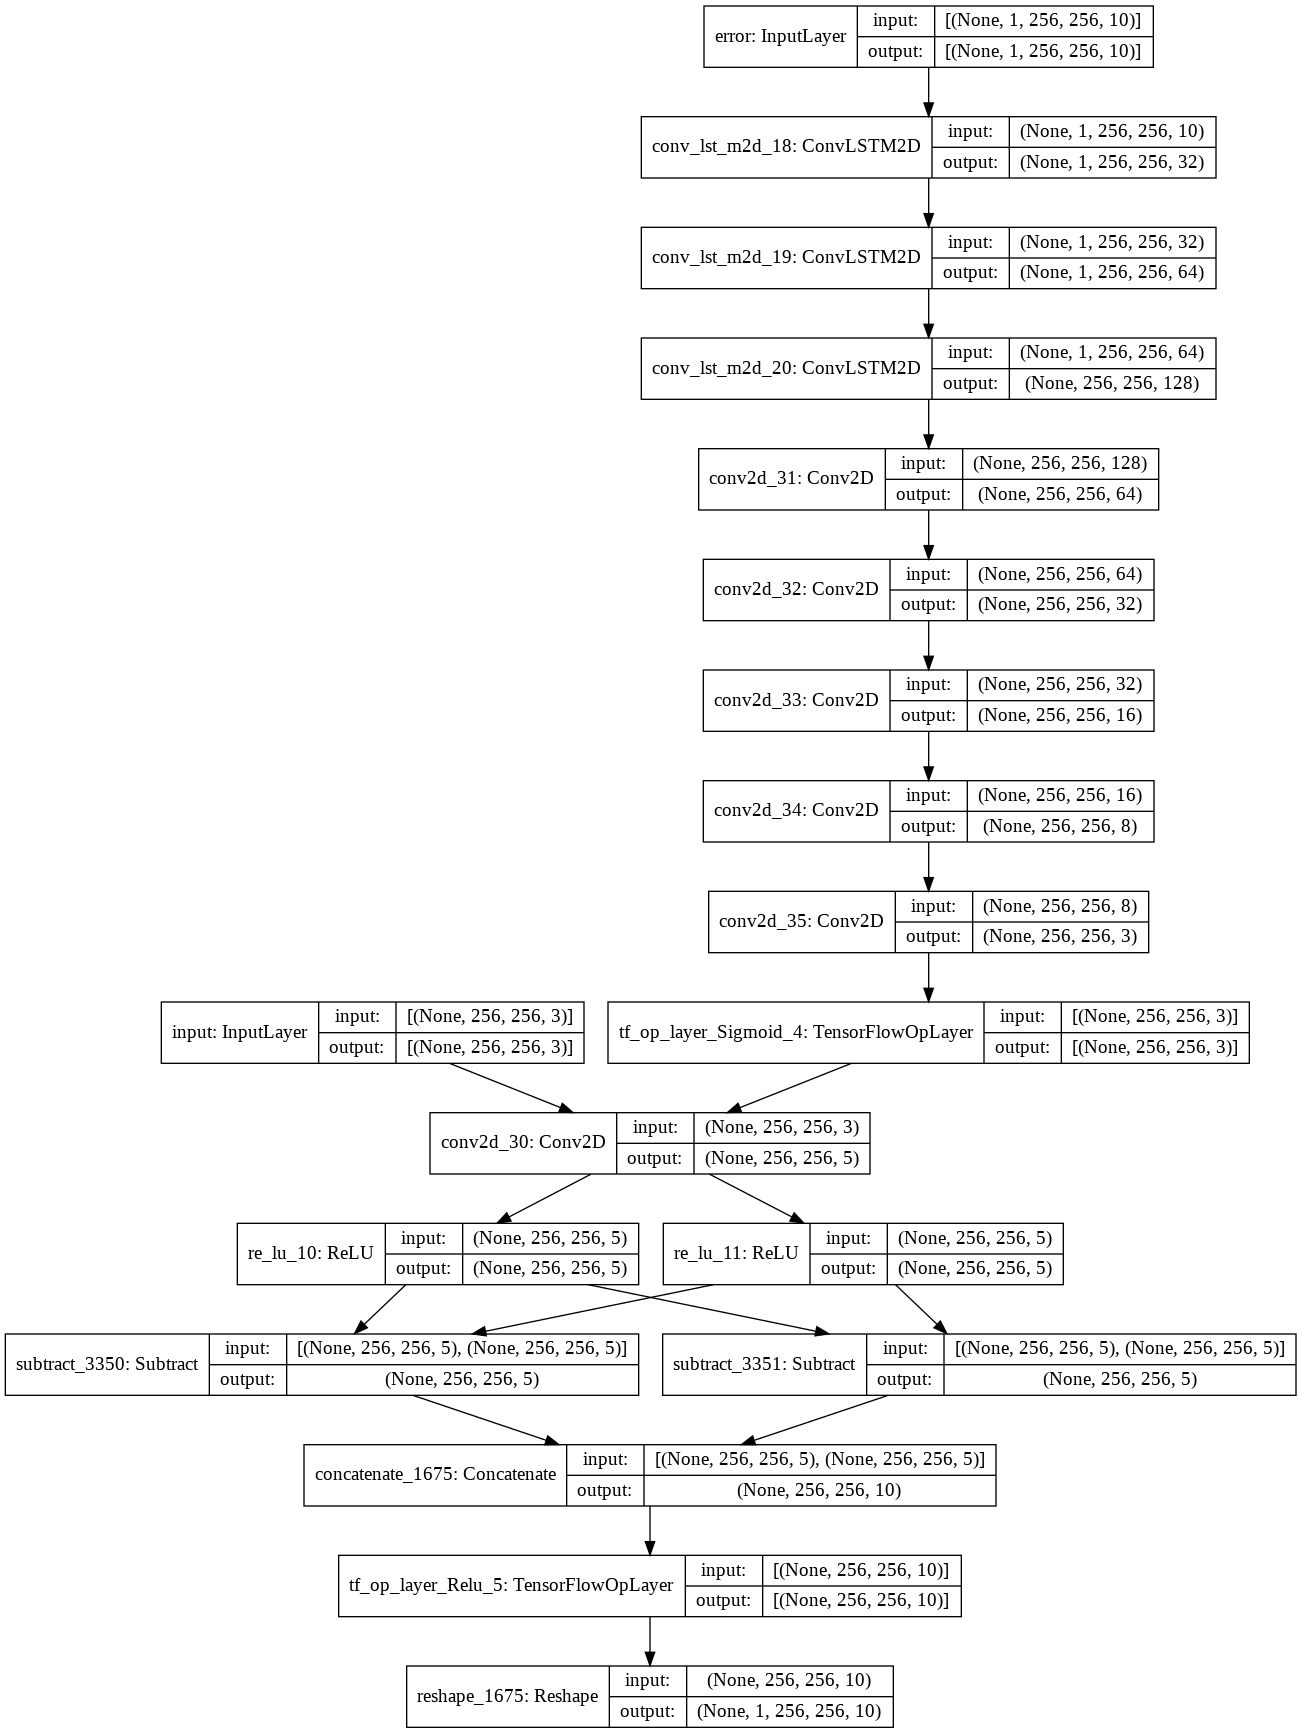

In [0]:
keras.utils.plot_model(pm, 'pm.png', show_shapes=True)
keras.utils.plot_model(hm, 'hm.png', show_shapes=True)

In [0]:
def get_loss(output, predict):
    return tf.keras.losses.binary_crossentropy(y_true = output, y_pred = predict)

In [0]:
def grad(aInput, aOutput, anE):
#   E = getError(conv(aInput), conv(aOutput))
#   hm.fit({'input':aInput, 'error':anE}, [E], 1, 1)
  pm.fit({'input':aInput, 'error':anE}, [aOutput], 1, 1)
  pred_img = pm.predict({'input':aInput, 'error': anE})
  next_E = hm.predict({'input':aInput, 'error': anE})
  
  return pred_img, E

Reset
Train on 1 samples
1/1 [==============================] - 2s 2s/sample - loss: 0.1831


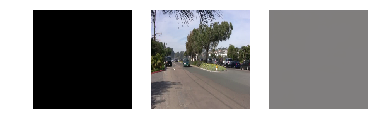

Train on 1 samples
1/1 [==============================] - 0s 386ms/sample - loss: 0.1822


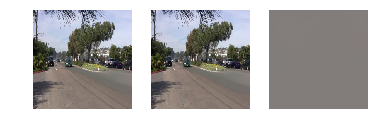

Train on 1 samples
1/1 [==============================] - 0s 342ms/sample - loss: 0.1810


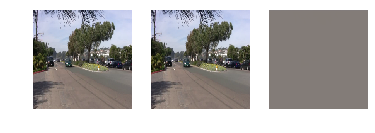

Train on 1 samples
1/1 [==============================] - 0s 345ms/sample - loss: 0.1791


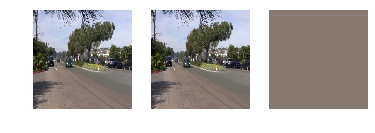

Train on 1 samples
1/1 [==============================] - 0s 342ms/sample - loss: 0.1775


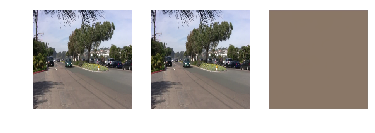

Train on 1 samples
1/1 [==============================] - 0s 343ms/sample - loss: 0.1796


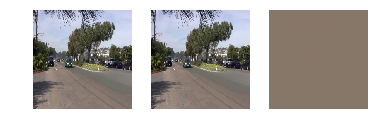

Train on 1 samples
1/1 [==============================] - 0s 341ms/sample - loss: 0.1785


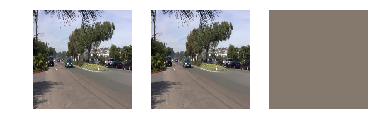

Train on 1 samples
1/1 [==============================] - 0s 347ms/sample - loss: 0.1775


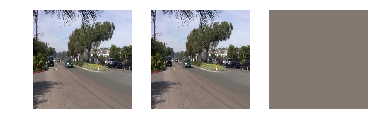

Train on 1 samples
1/1 [==============================] - 0s 342ms/sample - loss: 0.1772


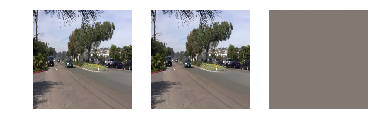

Train on 1 samples
1/1 [==============================] - 0s 346ms/sample - loss: 0.1776


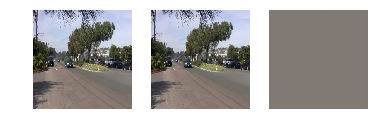

Train on 1 samples
1/1 [==============================] - 0s 344ms/sample - loss: 0.1779


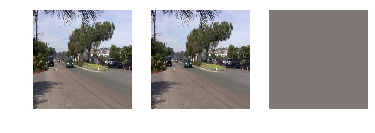

Train on 1 samples
1/1 [==============================] - 0s 343ms/sample - loss: 0.1779


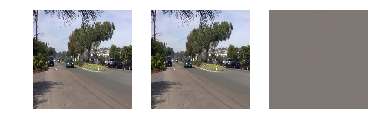

Train on 1 samples
1/1 [==============================] - 0s 342ms/sample - loss: 0.1779


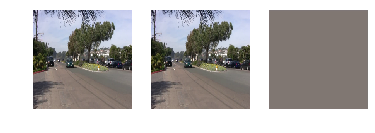

Train on 1 samples


In [0]:
for epoch in range(50):
  print("Reset")
  anE = getError(conv(imgSet[0].reshape(1, 256, 256, 3)), conv(imgSet[1].reshape(1, 256, 256, 3)))
  
  for i in range(len(imgSet)-1):
    in_im = imgSet[i].reshape((1, 256, 256, 3))
    ou_im = imgSet[i+1].reshape((1, 256, 256, 3))
    next_img, E = grad(in_im, ou_im, anE)
    
    fig, ax = plt.subplots(1, 3)
    ax[0].set_axis_off()
    ax[1].set_axis_off()
    ax[2].set_axis_off()
    
    ax[0].imshow(in_im.reshape((256, 256, 3)))
    ax[1].imshow(ou_im.reshape((256, 256, 3)))
    ax[2].imshow(next_img.reshape((256, 256, 3)))
    plt.show()
    
    anE = getError(conv(imgSet[i].reshape(1, 256, 256, 3)), conv(imgSet[i+1].reshape(1, 256, 256, 3)))